In [2]:
from api_setup import logger_setup, set_env_variables

logger_setup()
set_env_variables()

In [3]:
import spotipy #type: ignore
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth #type: ignore
from typing import Union, Any
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

## Plan

1. Get list of songs in each playlist
2. Get details from all songs

In [4]:
def get_playlists() -> list[str]:
    """
    Gets playlist codes from secrets nd loads into a list
    """

    playlists: list[str] = []

    with open('secrets/playlists.txt','r') as f:
        lines = f.readlines() 

        for line in lines:
            playlist_id = line[line.find('=')+1:-1]
            if playlist_id:
                playlists.append(playlist_id)
    
    return playlists

def get_songs_in_playlist(sp,pl_id):
    """
    Accesses the Spotify API to get the IDs of the songs with a given Playlist ID.
    """
    
    offset = 0

    response = sp.playlist_items(pl_id,
                                offset=offset,
                                fields='items.track.id,total',
                                additional_types=['track'])

    return response

def create_total_track_list(sp: spotipy.Spotify) -> tuple[set[str],list[dict[str,Union[str, list[str]]]]]:
    """
    Creates list of all tracks in each playlist
    """

    playlists: list[str] = get_playlists()

    track_ids: set[str] = set()
    playlist_contents: list[dict[str,Union[str, list[str]]]] = []
    
    for playlist in playlists:
        response = get_songs_in_playlist(sp,playlist)
        current_playlist_contents: dict[str,Union[str, list[str]]] = {'playlist_id':playlist, 'song_ids':response['items']}
        playlist_contents.append(current_playlist_contents)

        for item in response['items']:
            track_ids.add(item['track']['id'])

    return track_ids, playlist_contents

    

In [5]:
def get_song_properties(sp: spotipy.Spotify, track_ids: set[str]):
    track_list: list[str] = list(track_ids)
    n_tracks = len(track_list)
    track_features: list[dict[str,Any]] = []

    analysed_tracks: int = 0
    while analysed_tracks < n_tracks-1:
        response = sp.audio_features(track_list[analysed_tracks:analysed_tracks+99])
        analysed_tracks += 99
        track_features += response

    return track_features

        

In [6]:
client_credentials_manager = SpotifyClientCredentials()
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
scope = 'playlist-read-collaborative'
sp_personal = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))
tracklist, playlist_contents = create_total_track_list(sp)

In [7]:
track_features = get_song_properties(sp, tracklist)

In [8]:
dat_track_features = pd.DataFrame(track_features)
list(dat_track_features)

['danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'type',
 'id',
 'uri',
 'track_href',
 'analysis_url',
 'duration_ms',
 'time_signature']

In [9]:
graph_track_features = [
    'danceability',
    'energy',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration_ms']

categorical_track_features = [
    'key',
    'mode',
    'time_signature'
]

#### Danceability
Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
#### Energy
Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
#### Key
The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1. >= -1 <= 11
#### Loudness
The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.
#### Mode
Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
#### Speechiness
Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
#### Acousticness
A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
#### Instrumentalness
Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
#### Liveness
Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
#### Valence
A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). >= 0 <= 1
#### Tempo
The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
#### Type
The type of body. Always "audio features".
#### ID
The Spotify ID for the track.
#### URI
The Spotify URI for the track.
#### Track_href
The URL for the song
#### Analysis_url
A URL to access the full audio analysis of this track. An access token is required to access this data.
#### Duration_ms
The duration of the track in milliseconds.
#### Time_signature
An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4". >= 3 <= 7

In [10]:
dat_track_features.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000
mean,0.608426,0.680177,5.330409,-7.053497,0.621345,0.079831,0.199821,0.105028,0.194118,0.546290,126.030287,210368.266082,3.937135
std,0.165574,0.189422,3.565601,3.162767,0.485407,0.074334,0.254253,0.243511,0.153885,0.237532,27.223687,71490.874166,0.338580
min,0.066600,0.038800,0.000000,-30.791000,0.000000,0.024800,0.000027,0.000000,0.024600,0.029100,65.328000,43634.000000,1.000000
25%,0.496000,0.553000,2.000000,-8.544250,0.000000,0.037675,0.010775,0.000000,0.092575,0.369750,104.954750,165580.750000,4.000000
50%,0.620500,0.711000,5.000000,-6.465000,1.000000,0.053750,0.075950,0.000132,0.124000,0.556500,124.039500,198609.500000,4.000000
75%,0.732250,0.830000,8.000000,-4.886250,1.000000,0.085250,0.310250,0.031275,0.275500,0.727500,144.448000,238256.000000,4.000000
max,0.964000,0.989000,11.000000,-1.343000,1.000000,0.523000,0.983000,0.973000,0.895000,0.973000,205.863000,733307.000000,5.000000


In [11]:
dat_graph = dat_track_features[graph_track_features]

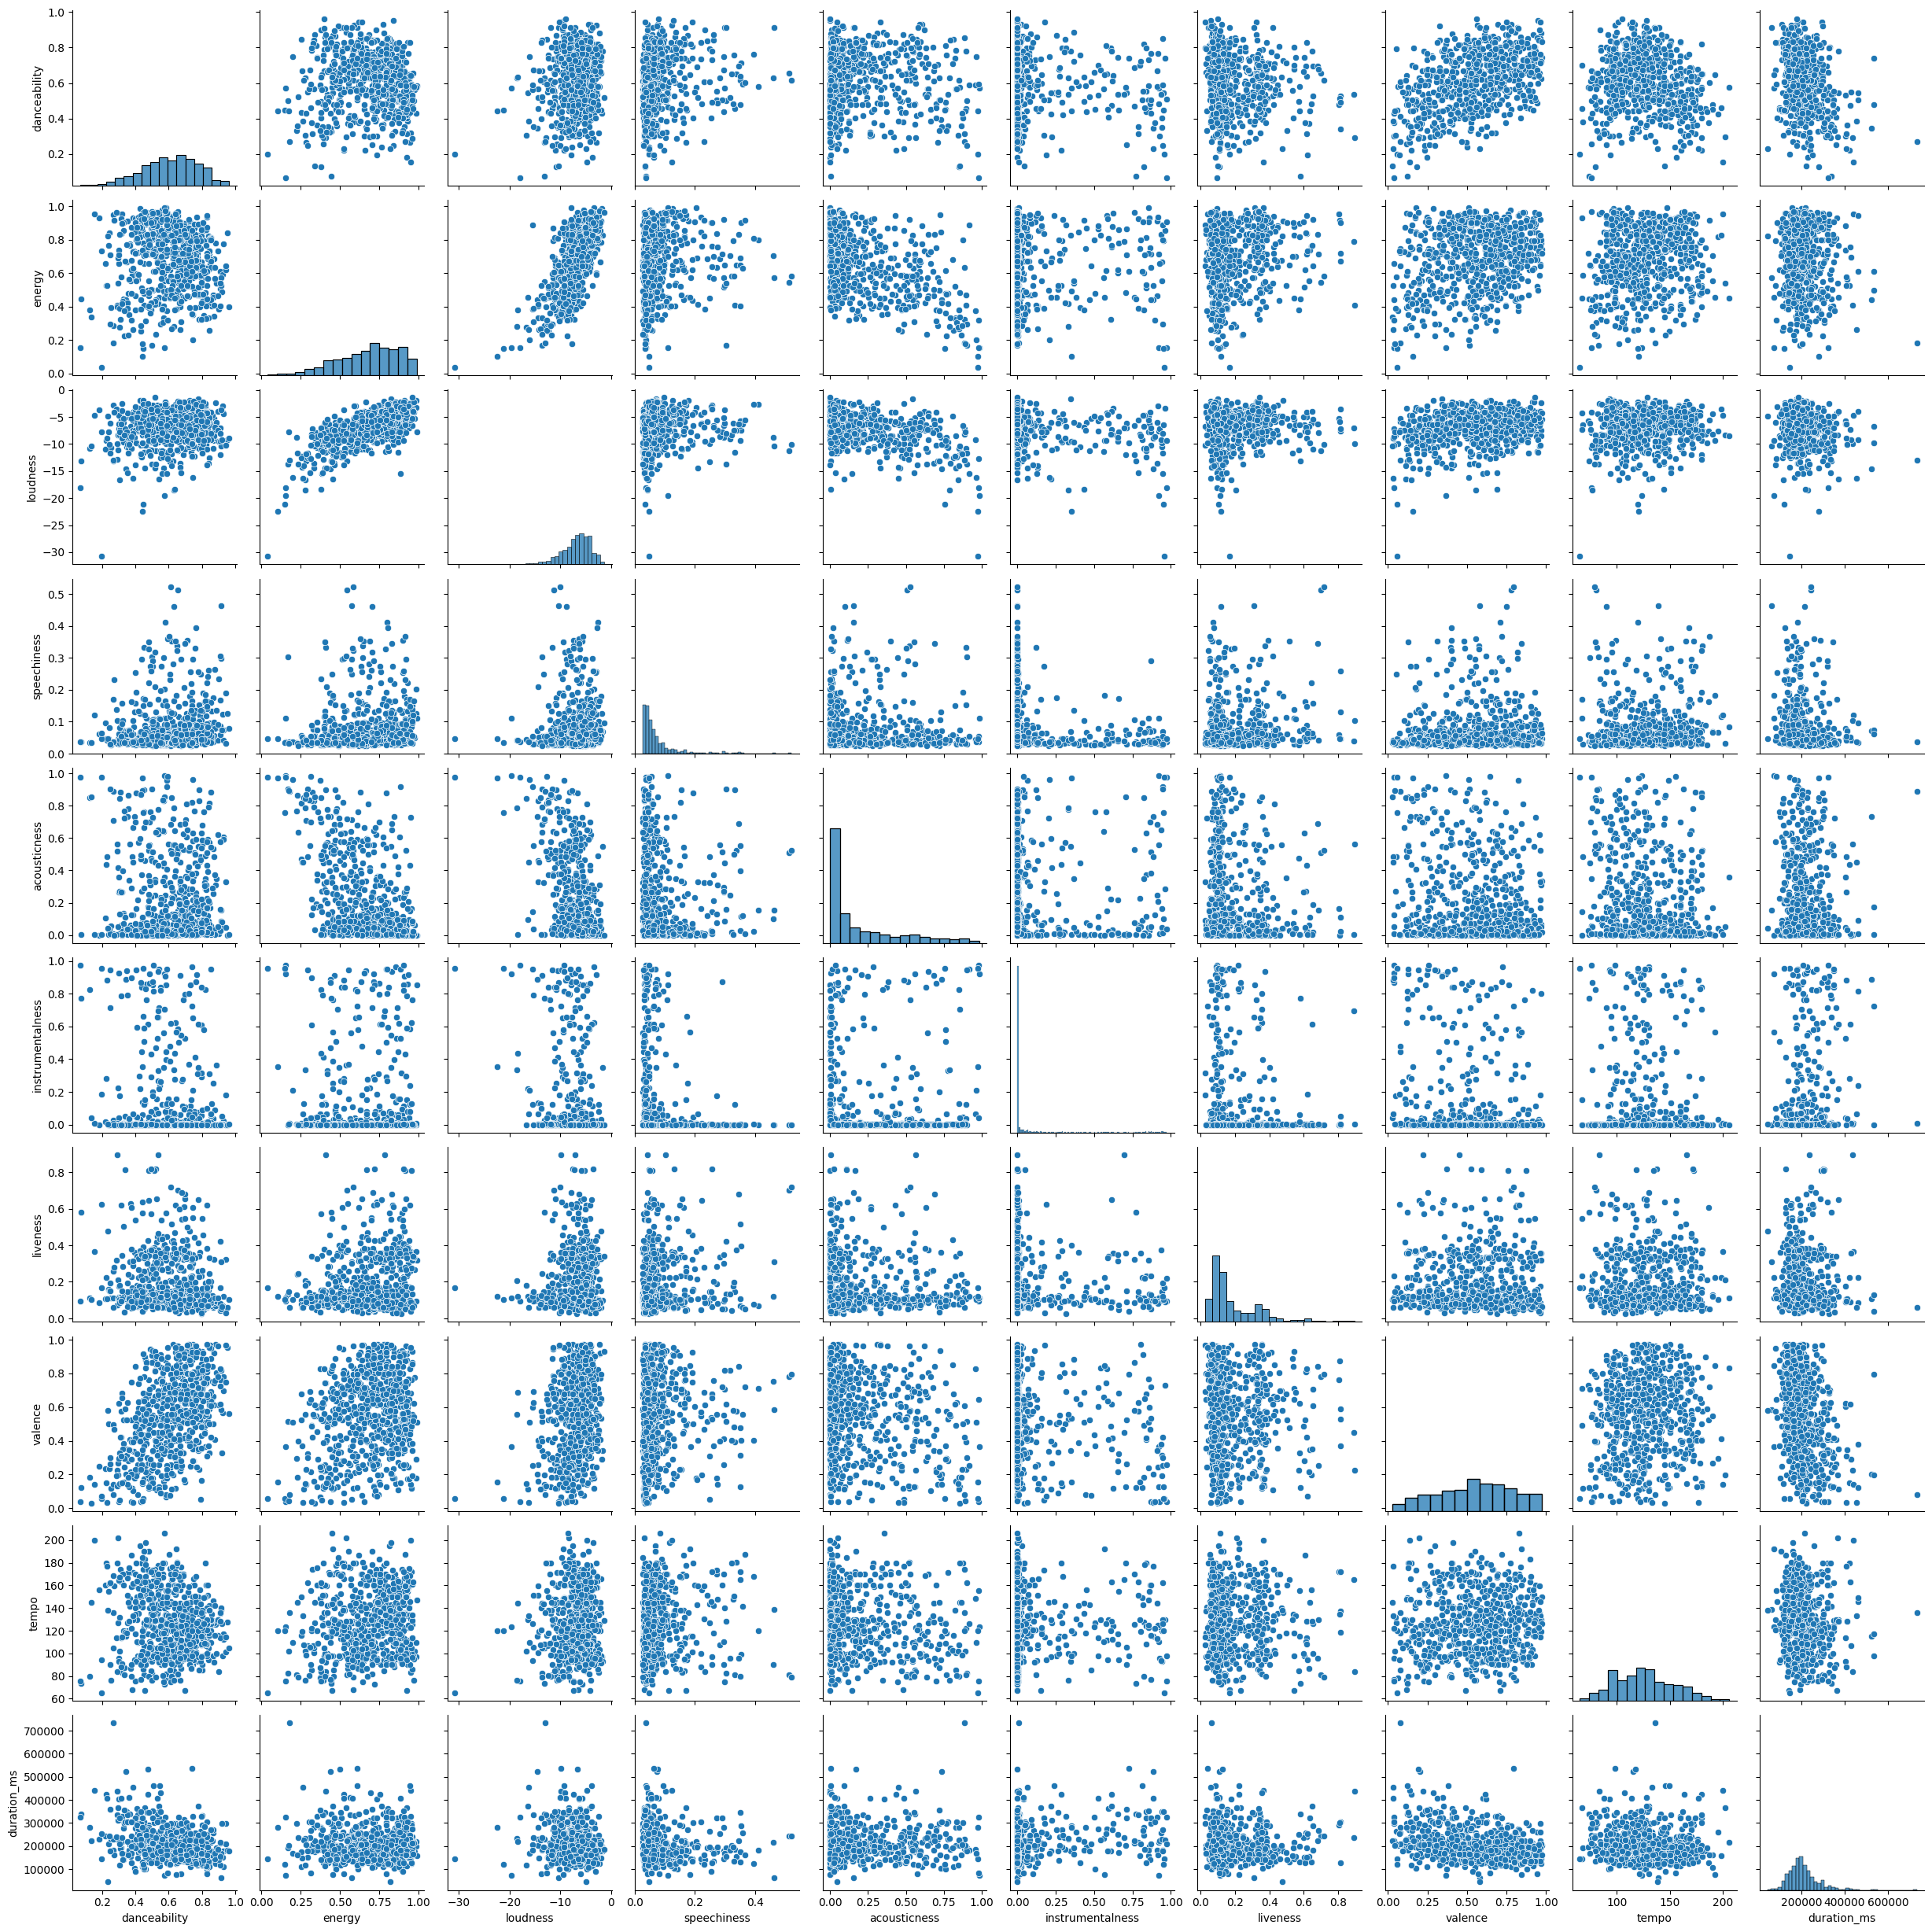

In [12]:
sns.pairplot(dat_graph)
plt.show()

In [13]:
# Create list of data frames
for playlist in playlist_contents:
    data = playlist['song_ids']
    playlist.update({'dataframe':pd.DataFrame(list(tracks['track']['id'] for tracks in data),columns=['id'])})
    playlist['dataframe'] = playlist['dataframe'].merge(dat_track_features, on='id', how='left')

In [14]:
playlist_contents[0]['dataframe'].head()

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,1xNknVNOolLB4oQeEtNBX2,0.736,0.669,1,-8.305,1,0.1360,0.1070,0.000000,0.2240,0.797,86.531,audio_features,spotify:track:1xNknVNOolLB4oQeEtNBX2,https://api.spotify.com/v1/tracks/1xNknVNOolLB...,https://api.spotify.com/v1/audio-analysis/1xNk...,172023,4
1,0TVwMTKyuSp41ytctKTA3T,0.803,0.636,11,-4.640,0,0.0322,0.0231,0.005050,0.0791,0.817,122.966,audio_features,spotify:track:0TVwMTKyuSp41ytctKTA3T,https://api.spotify.com/v1/tracks/0TVwMTKyuSp4...,https://api.spotify.com/v1/audio-analysis/0TVw...,205147,4
2,2STizqEu9scYzI5t3yqxSm,0.782,0.469,0,-10.876,1,0.1540,0.8970,0.033900,0.1070,0.228,122.020,audio_features,spotify:track:2STizqEu9scYzI5t3yqxSm,https://api.spotify.com/v1/tracks/2STizqEu9scY...,https://api.spotify.com/v1/audio-analysis/2STi...,190016,4
3,4gsR34XSIE2fUY4odwZqym,0.612,0.725,7,-5.602,1,0.0416,0.3050,0.078400,0.0548,0.333,146.008,audio_features,spotify:track:4gsR34XSIE2fUY4odwZqym,https://api.spotify.com/v1/tracks/4gsR34XSIE2f...,https://api.spotify.com/v1/audio-analysis/4gsR...,225667,4
4,4RFQqoOFw0pdropkjrPnh3,0.747,0.711,7,-4.270,1,0.0354,0.0291,0.000465,0.1010,0.353,113.007,audio_features,spotify:track:4RFQqoOFw0pdropkjrPnh3,https://api.spotify.com/v1/tracks/4RFQqoOFw0pd...,https://api.spotify.com/v1/audio-analysis/4RFQ...,184871,4


In [15]:
for playlist in playlist_contents:
    averages = playlist['dataframe'].mean()
    playlist.update({'danceability':averages['danceability'],
                     'energy':averages['energy'],
                     'loudness':averages['loudness'],
                     'mode':averages['mode'],
                     'speechiness':averages['speechiness'],
                     'acousticness':averages['acousticness'],
                     'instrumentalness':averages['instrumentalness'],
                     'liveness':averages['liveness'],
                     'valence':averages['valence'],
                     'tempo':averages['tempo'],
                     'duration_ms':averages['duration_ms']})

C:\Users\ph7st\AppData\Local\Temp\ipykernel_9144\2025921382.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  averages = playlist['dataframe'].mean()
C:\Users\ph7st\AppData\Local\Temp\ipykernel_9144\2025921382.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  averages = playlist['dataframe'].mean()
C:\Users\ph7st\AppData\Local\Temp\ipykernel_9144\2025921382.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only

In [16]:
playlist_contents[0].keys()

dict_keys(['playlist_id', 'song_ids', 'dataframe', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms'])

In [17]:
playlist_id = []
danceability = []
energy = []
loudness = []
mode = []
speechiness = []
acousticness = []
instrumentalness = []
liveness = []
valence = []
tempo = []
duration_ms = []

for playlist in playlist_contents:
    playlist_id.append(playlist['playlist_id'])
    danceability.append(playlist['danceability'])
    energy.append(playlist['energy'])
    loudness.append(playlist['loudness'])
    mode.append(playlist['mode'])
    speechiness.append(playlist['speechiness'])
    acousticness.append(playlist['acousticness'])
    instrumentalness.append(playlist['instrumentalness'])
    liveness.append(playlist['liveness'])
    valence.append(playlist['valence'])
    tempo.append(playlist['tempo'])
    duration_ms.append(playlist['duration_ms'])

playlist_averages = pd.DataFrame({'playlist_id':playlist_id,
                                  'danceability':danceability,
                                  'energy':energy,
                                  'loudness':loudness,
                                  'mode':mode,
                                  'speechiness':speechiness,
                                  'acousticness':acousticness,
                                  'instrumentalness':instrumentalness,
                                  'liveness':liveness,
                                  'valence':valence,
                                  'tempo':tempo,
                                  'duration_ms':duration_ms})

In [18]:
playlist_averages.head()

,playlist_id,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,7LKlohm1GDF9ZLK9dQMqg9,0.656429,0.648143,-6.973714,0.714286,0.067200,0.201629,0.022417,0.103157,0.428714,115.104143,204448.428571
1,60D2tI0u8xisQ8iaebEa1f,0.663700,0.675300,-7.464300,0.500000,0.065180,0.148696,0.021568,0.181180,0.677600,110.774300,226853.600000
2,1RV67lj8IvbTREkStrkZ61,0.773000,0.743000,-6.450500,0.500000,0.039800,0.509500,0.004995,0.193500,0.622500,119.976000,204784.500000
3,7HeSjoPZ1sTCUP69qbkyuY,0.691250,0.515375,-8.886000,0.375000,0.053437,0.463375,0.007014,0.114913,0.546125,117.567750,231335.375000
4,7npaP2hZWDAcpWqspmmQ8K,0.665650,0.603300,-7.273050,0.450000,0.069265,0.286470,0.066251,0.162960,0.610600,116.888900,207326.450000


Parse data and allocate to people

In [19]:
rand_names = ['Oliver','Declan','Niamh','Aurora','Silas','Luna']

In [59]:
playlist_owner_data = []
real_names_list = [] 

with open('secrets\playlists.txt') as f:
    for line in f.readlines():
        playlist_id = line[line.find('=')+1:-1]
        name_date = line[0:line.find('=')].split('_')
        name_date.append(playlist_id)
        
        # Obscure real names
        if name_date[0] not in real_names_list:
            real_names_list.append(name_date[0])
        
        name_date[0] = rand_names[real_names_list.index(name_date[0])]
        playlist_owner_data.append(name_date)

dat_playlist_owner_data = pd.DataFrame(playlist_owner_data, columns=['name', 'month', 'year', 'playlist_id'])

In [60]:
dat_playlist_owner_data.head()

,name,month,year,playlist_id
0,Oliver,feb,23,7LKlohm1GDF9ZLK9dQMqg9
1,Oliver,jan,23,60D2tI0u8xisQ8iaebEa1f
2,Oliver,dec,22,1RV67lj8IvbTREkStrkZ61
3,Oliver,nov,22,7HeSjoPZ1sTCUP69qbkyuY
4,Oliver,oct,22,7npaP2hZWDAcpWqspmmQ8K


In [61]:
month_match = pd.DataFrame({'month':['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'],
                            'month_nr':[1,2,3,4,5,6,7,8,9,10,11,12]})

In [62]:
owner_playlist_averages = dat_playlist_owner_data.merge(playlist_averages,on='playlist_id').merge(month_match,on='month')
owner_playlist_averages = owner_playlist_averages.assign(date_month = lambda x: pd.to_datetime({'year':"20"+x.year, 'month':x.month_nr, 'day':[1]*len(owner_playlist_averages)},format="%y%m%d"))
owner_playlist_averages = owner_playlist_averages.sort_values(by=['date_month'])
owner_playlist_averages.head()


,name,month,year,playlist_id,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,month_nr,date_month
19,Declan,dec,21,34HQ3n3Wo4VoiG1Miqvj2T,0.516429,0.598333,-8.539286,0.571429,0.077876,0.345466,0.265595,0.174243,0.312333,119.773095,284972.476190,12,2021-12-01
23,Aurora,dec,21,0OvuatMCvupsaom5Evk85Y,0.664375,0.679625,-6.119250,0.750000,0.086350,0.200619,0.001987,0.139219,0.596875,132.692187,187761.625000,12,2021-12-01
21,Niamh,dec,21,4ZAyBJo8jK5TJaN4YK3ITU,0.724556,0.645611,-6.023278,0.777778,0.088339,0.258561,0.040657,0.161317,0.610722,133.157000,204318.944444,12,2021-12-01
18,Oliver,dec,21,0Nfz9b9QZJIrZHyNPg0ZX7,0.630600,0.719500,-5.647100,0.600000,0.082220,0.129464,0.160003,0.140190,0.543370,117.725600,209510.600000,12,2021-12-01
9,Oliver,jan,22,4DOHoClpS9623fJL4oMFxB,0.712900,0.613300,-7.465500,0.600000,0.049470,0.266153,0.010127,0.125990,0.617770,109.367400,196028.000000,1,2022-01-01


<Axes: xlabel='date_month', ylabel='energy'>

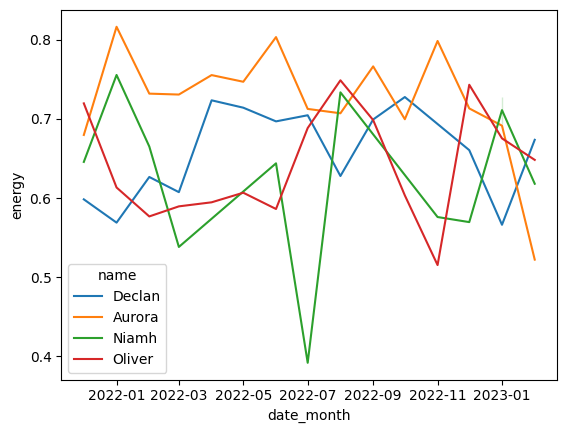

In [63]:
sns.lineplot(data=owner_playlist_averages, x='date_month', y='energy', hue='name')


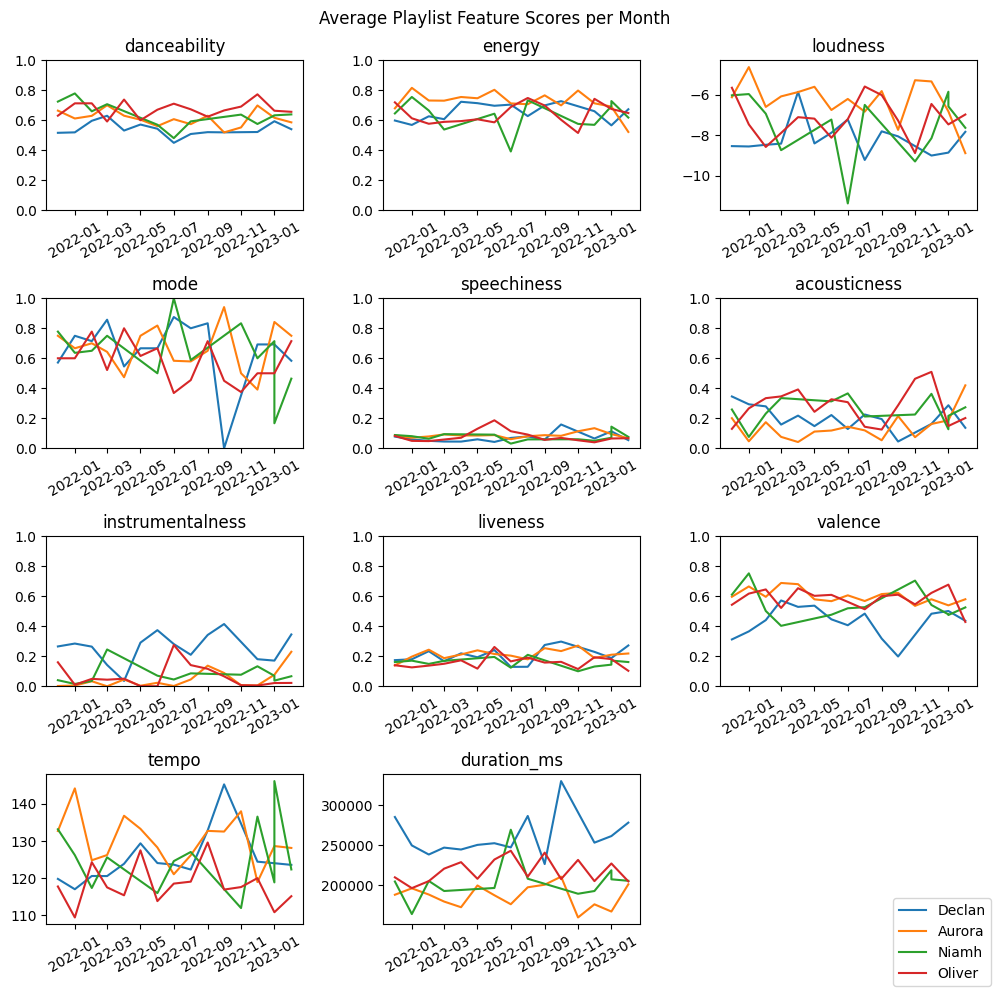

In [65]:
name_list = owner_playlist_averages['name'].unique()
counter = 0

graph_features = ['danceability',
                  'energy',
                  'loudness',
                  'mode',
                  'speechiness',
                  'acousticness',
                  'instrumentalness',
                  'liveness',
                  'valence',
                  'tempo',
                  'duration_ms']

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10,10))

for i in range(4):
    for j in range(3):
        if i == 3 and j == 2:
            continue
        for active_name in name_list:
            active_data = owner_playlist_averages.query('name == @active_name')
            axs[i,j].plot(active_data['date_month'], active_data[graph_features[counter]], )
            axs[i,j].title.set_text(graph_features[counter])
            axs[i,j].xaxis.set_tick_params(rotation=30)
            if graph_features[counter] != "loudness" and graph_features[counter] != "tempo" and graph_features[counter] != "duration_ms":
                axs[i,j].set_ylim(0,1)
        
        counter += 1

axs[3,2].axis('off')
fig.legend(name_list,loc='lower right')
fig.suptitle("Average Playlist Feature Scores per Month")
fig.tight_layout()
plt.show()

In [72]:
dat_playlist_owner_data.head().merge(month_match,on='month')

,name,month,year,playlist_id,month_nr
0,Oliver,feb,23,7LKlohm1GDF9ZLK9dQMqg9,2
1,Oliver,jan,23,60D2tI0u8xisQ8iaebEa1f,1
2,Oliver,dec,22,1RV67lj8IvbTREkStrkZ61,12
3,Oliver,nov,22,7HeSjoPZ1sTCUP69qbkyuY,11
4,Oliver,oct,22,7npaP2hZWDAcpWqspmmQ8K,10


In [68]:
playlist_contents[0].keys()

dict_keys(['playlist_id', 'song_ids', 'dataframe', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms'])

In [76]:
for year in range(21,24):
    for month in range(1,13):
        print(year," ", month)

22   1
22   2
22   3
22   4
22   5
22   6
22   7
22   8
22   9
22   10
22   11
22   12
23   1
23   2
23   3
23   4
23   5
23   6
23   7
23   8
23   9
23   10
23   11
23   12
